# Haario's Method
As in [exercise 05a](05a_MetropolisAlgorithm.ipynb) and [exercise 05b](05b_StepSize_in_MCMC.ipynb), we consider the data `data_ex05.npy`. The same assumption of previous exercises apply. The goal is still to estimate $\mu$ and $\sigma$ as posterior averages (with errors given by posterior standard deviations) from the data, using Metropolis algorithm to sample. 

In this notebook we will compare standard Metropolis with the Haario's method. 

## Introduction
The idea behind Haario's method is that in Metropolis Algorithm we can do something beetter than just considering different thresholds. Indeed, when selecting the jump distribution we could capture some properties of the target distribution, as:
- $\vec{m}$, the mean of the target distribution, $\vec{M}=\left(\mathbb{E}(\mu), \mathbb{E}(\sigma)\right)$
- $\vec{\Sigma}$, the covariance of the target distribution, that characterizes the shape of the peak

> The Haario's strategy to fix the jump distribution is to match the covariance of the jump and the covariance of the target.

**BUT...** we don't know the target covariance! The solution is to compute the empirical covariance of observations as the chain progresses, considering $M$ points in the chain:
$$
    X_n \quad, \quad n=k, \dots, k+M
$$
This is motivated by the fact that the running average and the running covariance are expected to slowly converge to the target. Then, the proposal step $T(\mu', \sigma'| \mu, \sigma)$ is normal with covariance given by $\Sigma^{emp}$:
$$
    (\mu', \sigma') \sim \mathcal{N}\left((\mu, \sigma), \Sigma^{emp}\right) 
$$ 



## Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import math 

from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

data = np.load('./data/data_ex05.npy')
print('There are %i data points' %len(data))

There are 10000 data points


In [2]:
def log_likelihood(x, mu, sigma):
    return np.log(1/np.sqrt(2*np.pi*sigma))-0.5*(x-mu)**2/(sigma**2)

def log_prior_mu(mu, m, s):
    return np.log(1/np.sqrt(2*np.pi*s))-0.5*(mu-m)**2/(s**2)

def log_prior_sigma(sigma, alpha, beta):
    def inverse_gamma(x, alpha_, beta_):
        return beta_**alpha_/math.gamma(alpha_)*(1/x)**(alpha+1)*np.exp(-beta_/x)
        
    return np.log(inverse_gamma(sigma, alpha, beta))

def log_posterior(mu, sigma, x, m=4, s=2, alpha=2, beta=1):
    return np.sum(log_likelihood(x, mu, sigma)) + log_prior_mu(mu, m, s) + log_prior_sigma(sigma, alpha, beta)

In [3]:
def metropolis(p0, n_samples, burn_in, epsilon=0.005, x=data, log_func_post=log_posterior):
    '''
    INPUTS:
    p0            -> initial state of the Markov Chain, [mu_0, sigma_0]
    n_samples     -> number of required samples
    burn_in       -> discarded initial samples
    x             -> data samples
    log_func_post -> function returning a ln of the posterior distribution, not normalized with the evidence
    
    OUTPUT: 
    f_sampled     -> MCMC chain, shape (2, n_samples)
    r_accept      -> acceptance rate (computed only after the burn in)
    
    '''
    
    p_current = p0
    f_current = log_func_post(mu=p_current[0], sigma=p_current[1], x=x)  
        
    # initialize the chain object
    f_sampled = np.zeros((2, n_samples))
    f_burnin = np.zeros((2, burn_in))
    
    # acceptance/rejection rate
    n_accept = 0
    
    # MCMC algorithm
    i = 0
    while i<(burn_in + n_samples):
        # draw random sample
        p_prop = np.random.multivariate_normal(mean=p_current, cov=epsilon*np.eye(2))
        
        # Metropolis step
        if p_prop[1]>0:
            f_prop = log_posterior(mu=p_prop[0], sigma=p_prop[1], x=x)
            logMR =  f_prop - f_current
        else:
            logMR = -np.inf
        
        if logMR >= 0 or logMR >= np.log(np.random.uniform(0, 1)):
            p_current = p_prop
            f_current = f_prop 
            if i >= burn_in: 
                n_accept += 1
            
        if i >= burn_in:
            f_sampled[:, i-burn_in] = p_current
        else:
            f_burnin[:, i] = p_current
        
        i += 1
    
    r_accept = n_accept/n_samples
    
    return f_sampled, f_burnin, r_accept



def metropolis_HM(p0, n_samples, burn_in, epsilon=0.005, M=200, x=data, log_func_post=log_posterior):
    '''
    INPUTS:
    p0            -> initial state of the Markov Chain, [mu_0, sigma_0]
    n_samples     -> number of required samples
    burn_in       -> discarded initial samples
    x             -> data samples
    log_func_post -> function returning a ln of the posterior distribution, not normalized with the evidence
    
    OUTPUT: 
    f_sampled     -> MCMC chain, shape (2, n_samples)
    r_accept      -> acceptance rate (computed only after the burn in)
    
    '''
    
    p_current = p0
    f_current = log_func_post(mu=p_current[0], sigma=p_current[1], x=x)  
        
    # initialize the chain object
    f_sampled_tot = np.zeros((2, burn_in+n_samples))
    
    # acceptance/rejection rate
    n_accept = 0
    
    # MCMC algorithm
    i = 0
    while i<(burn_in + n_samples):
        # compute covariance
        if i<burn_in: # accumulate chain data, use standard method
            p_prop = np.random.multivariate_normal(mean=p_current, cov=epsilon*np.eye(2))
            
        else: # Haario's method can be used
            considered_samples = f_sampled_tot[:, i-M:i]
            emp_cov = np.cov(considered_samples)
                
            p_prop = np.random.multivariate_normal(mean=p_current, cov=emp_cov)
            
        # Metropolis step
        if p_prop[1]>0:
            f_prop = log_posterior(mu=p_prop[0], sigma=p_prop[1], x=x)
            logMR =  f_prop - f_current
        else:
            logMR = -np.inf
        
        if logMR >= 0 or logMR >= np.log(np.random.uniform(0, 1)):
            p_current = p_prop
            f_current = f_prop 
            if i >= burn_in: 
                n_accept += 1
            
        f_sampled_tot[:, i] = p_current
        
        i += 1
    
    r_accept = n_accept/n_samples
    
    return f_sampled_tot[:, burn_in:], f_sampled_tot[:, :burn_in], r_accept


In [4]:
p0 = np.array([4, 1])
burn_in = 2000
n_steps = 50000

chains, burnin, acc_rate = metropolis(p0, n_samples=n_steps, burn_in=burn_in, epsilon=0.0001)    
print("The acceptance rate with the standard method is %.3f%%" %(acc_rate*100))


The acceptance rate with the standard method is 46.080%


In [5]:
chains_HM, burnin_HM, acc_rate_HM = metropolis_HM(p0, n_samples=n_steps, burn_in=burn_in, epsilon=0.0001)
print("The acceptance rate with the Haario's Method is %.3f%%" %(acc_rate_HM*100))

The acceptance rate with the Haario's Method is 56.980%


## Marginal distributions

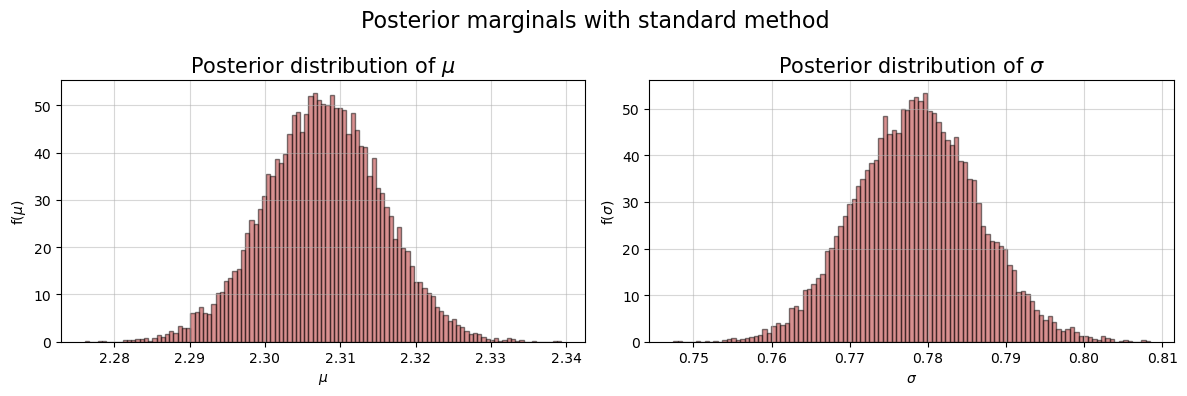

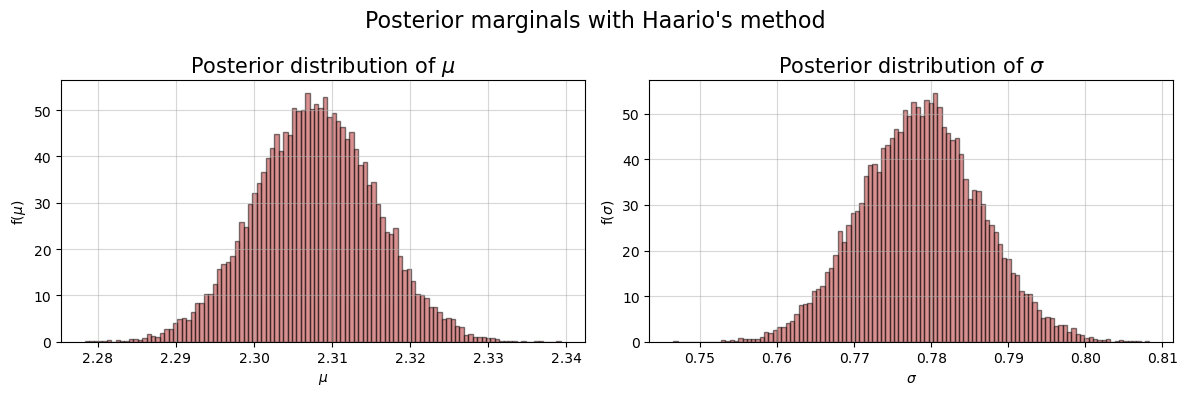

In [6]:
def hist_marginals(chains_, method_name):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    hist_0 = ax[0].hist(chains_[0, :], bins='fd', edgecolor='black', alpha=0.5, density=True, color='firebrick')
    hist_1 = ax[1].hist(chains_[1, :], bins='fd', edgecolor='black', alpha=0.5, density=True, color='firebrick')
    
    labels = ['$\mu$', '$\sigma$']
    for i, lab in enumerate(labels):
        ax[i].set_xlabel(lab, fontsize=10)
        ax[i].set_ylabel('f('+lab+')', fontsize=10)
        ax[i].grid(alpha=0.5)
        ax[i].set_title('Posterior distribution of '+lab, fontsize=15)
        
    fig.suptitle('Posterior marginals with '+method_name, fontsize=16)

    plt.tight_layout()
    plt.show()
    
    variables_mean = np.mean(chains_, axis=1)
    variables_std  = np.std(chains_, axis=1)
    
    return variables_mean, variables_std

variables_mean_ST, variables_std_ST = hist_marginals(chains, "standard method")
variables_mean_HM, variables_std_HM = hist_marginals(chains_HM, "Haario's method")


In [7]:
print("Standard Method:")
print('mu    = %.3f +- %.5f' %(variables_mean_ST[0], variables_std_ST[0]))
print('sigma = %.3f +- %.5f' %(variables_mean_ST[1], variables_std_ST[1]))

print("\nHaario's Method:")
print('mu    = %.3f +- %.5f' %(variables_mean_HM[0], variables_std_HM[0]))
print('sigma = %.3f +- %.5f' %(variables_mean_HM[1], variables_std_HM[1]))

Standard Method:
mu    = 2.308 +- 0.00777
sigma = 0.779 +- 0.00781

Haario's Method:
mu    = 2.308 +- 0.00768
sigma = 0.779 +- 0.00772


## Chain analysis

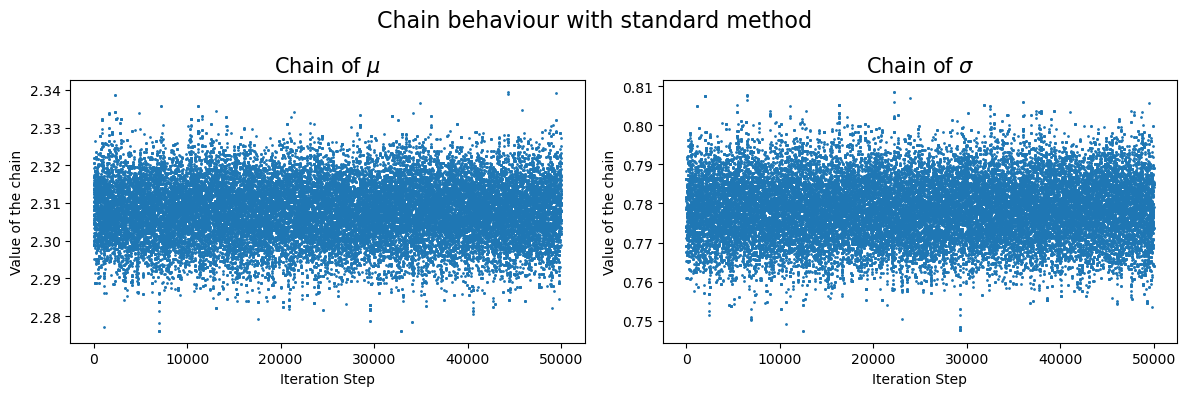

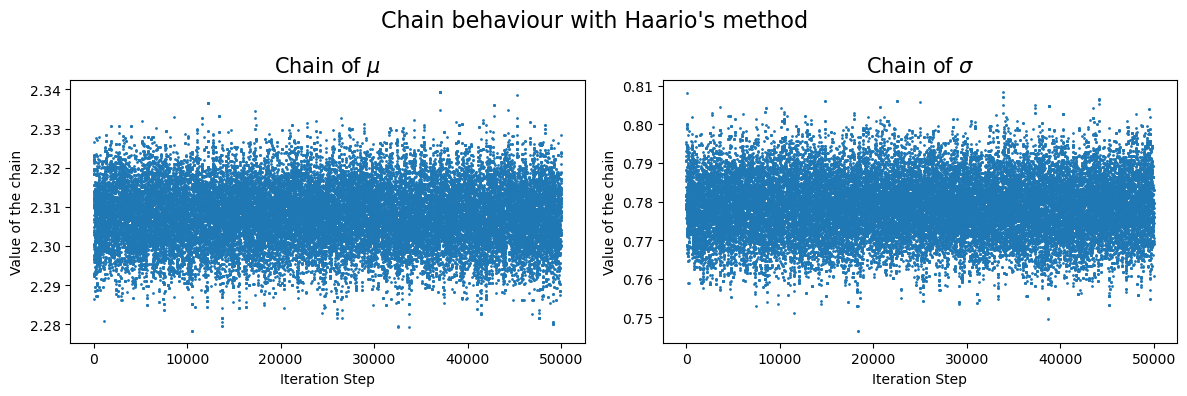

In [8]:
def plot_chain(chain_samples, var_names, plot_suptitle):

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(plot_suptitle, fontsize=16)
    
    for i in range(2):
        ax[i].scatter(range(0, chain_samples.shape[1]) , chain_samples[i, :], s=1)
        ax[i].set_xlabel('Iteration Step', fontsize=10)
        ax[i].set_ylabel('Value of the chain', fontsize=10)
        ax[i].set_title('Chain of '+ var_names[i], fontsize=15)
        
    plt.tight_layout()
    plt.show()
    
plot_chain(chains, ['$\mu$', '$\sigma$'], "Chain behaviour with standard method")
plot_chain(chains_HM, ['$\mu$', '$\sigma$'], "Chain behaviour with Haario's method")

## Analysis of burn-in phase

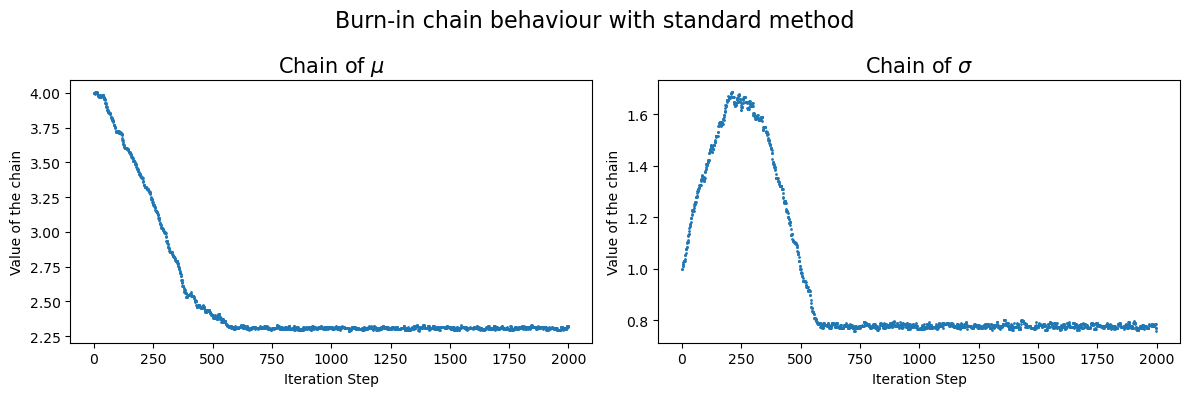

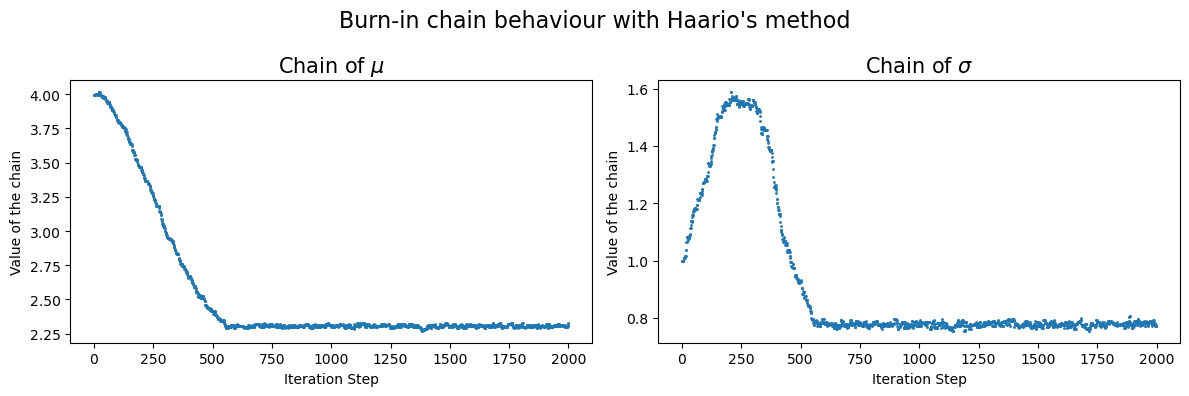

In [9]:
plot_chain(burnin, ['$\mu$', '$\sigma$'], "Burn-in chain behaviour with standard method")
plot_chain(burnin_HM, ['$\mu$', '$\sigma$'], "Burn-in chain behaviour with Haario's method")

## Looking for correlations

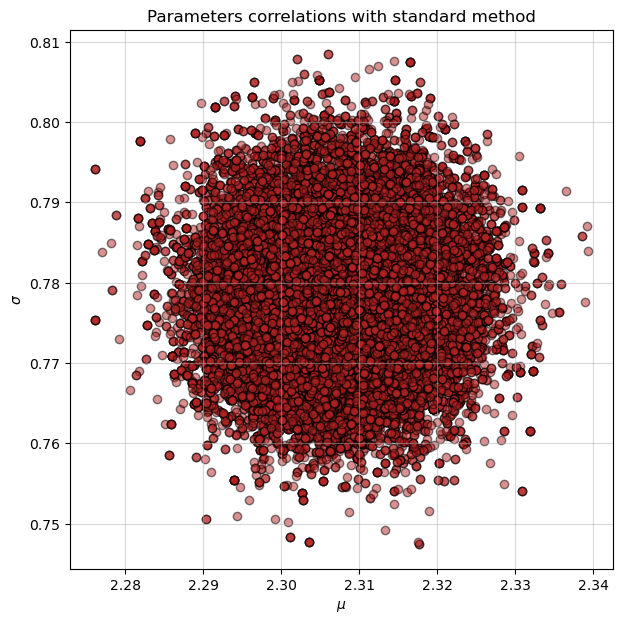

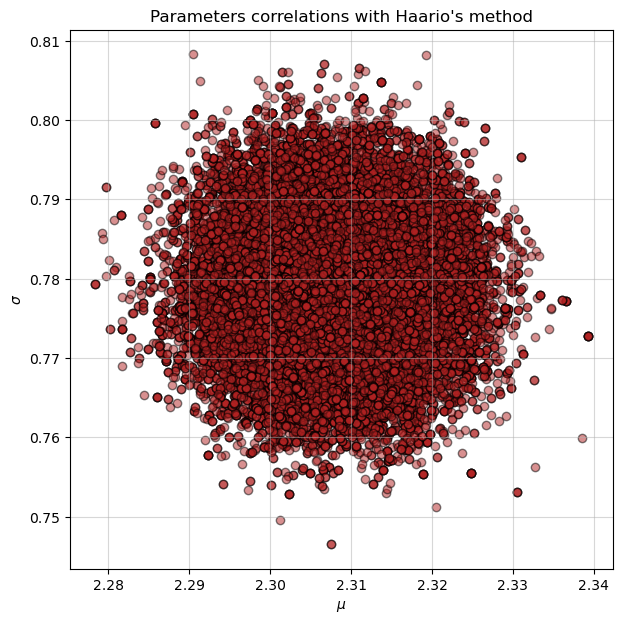

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
    
ax.scatter(chains[0, :], chains[1, :], edgecolors = 'black', facecolors='firebrick', alpha=0.5)
ax.set_xlabel('$\mu$', fontsize=10)
ax.set_ylabel('$\sigma$', fontsize=10)
ax.grid(alpha=0.5)

ax.set_title("Parameters correlations with standard method")

plt.show()


fig, ax = plt.subplots(figsize=(7, 7))
    
ax.scatter(chains_HM[0, :], chains_HM[1, :], edgecolors = 'black', facecolors='firebrick', alpha=0.5)
ax.set_xlabel('$\mu$', fontsize=10)
ax.set_ylabel('$\sigma$', fontsize=10)
ax.grid(alpha=0.5)

ax.set_title("Parameters correlations with Haario's method")

plt.show()

In [11]:
# plot_acf(
#     chains[0, :], lags=200, 
#     use_vlines=False, title='Autocorrelation of $\mu$'
# )
# fig = plt.gcf()
# fig.set_size_inches(12, 7)

# ax = plt.gca()
# ax.grid(alpha=0.5)
# ax.set_ylim(-0.2)
# ax.set_xlabel('lag')
# ax.set_ylabel('ACF')

# plt.show()


# plot_acf(
#     chains[1, :], lags=200, 
#     use_vlines=False, title='Autocorrelation of $\sigma$'
# )
# fig = plt.gcf()
# fig.set_size_inches(12, 7)

# ax = plt.gca()
# ax.grid(alpha=0.5)
# ax.set_ylim(-0.2)
# ax.set_xlabel('lag')
# ax.set_ylabel('ACF')

# plt.show()
